In [1]:
#load data
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import os
import geffnet #efficientnet-b2

%matplotlib inline
sns.set_style('darkgrid')
np.random.seed(0)
torch.manual_seed(0)

C:\Users\wjdth\anaconda3\envs\torchvenv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
root_dir = "C:/Users/wjdth/kuiai/data/"
print("The data lies here =>", root_dir)

We're using => cpu
The data lies here => C:/Users/wjdth/kuiai/data/


In [3]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])
}

In [4]:
train_dataset = datasets.ImageFolder(root = root_dir + "train",
                                   transform = image_transforms["train"])
test_dataset = datasets.ImageFolder(root = root_dir + "test",
                                   transform = image_transforms["test"])

In [5]:
train_dataset_size = len(train_dataset)
train_dataset_indices = list(range(train_dataset_size))
train_sampler = SubsetRandomSampler(train_dataset_indices)
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=4, sampler=train_sampler)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

In [80]:
# model.state_dict().keys()

In [6]:
# Loading the model
model = geffnet.create_model('efficientnet_b2', pretrained=True)

# Freezing all the layers
for param in model.parameters():
    param.requires_grad = False

# Changing the Classifier
model.classifier = nn.Sequential(
        nn.Linear(1408,512),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(128,8))

# Making the Classifier layer Trainable                           
for param in model.classifier.parameters():
    param.requires_grad = True
    
# param_list = ['conv_head.weight', 'bn2.weight', 'bn2.bias']
for name, param in model.named_parameters():
    if name in ['conv_head.weight', 'bn2.weight', 'bn2.bias']:
        param.requires_grad = True

# Moving the model to device
model.to(device)
print(model)

GenEfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): Depthwise

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.classifier.parameters(),lr = 0.001)

In [8]:
loss_stats = {
    'train': [],
    "val": []
}

In [9]:
print("Begin training.")
for e in tqdm(range(1, 30)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for images, labels in train_loader:
        # Move tensor to device('cuda' in case of GPU or 'cpu' in case of CPU)
        images, labels = images.to(device), labels.to(device)
        # Clearing all the previous gradients
        optimizer.zero_grad()
        # Forward Pass
        logits = model(images)
        # Loss calculation
        loss = criterion(logits,labels)
        # Backward Pass
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Updating the losses list
        train_epoch_loss += loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f}')
    
torch.save(model.state_dict(), 'model_epoch30.pt')

Begin training.


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 2.10338
Epoch 02: | Train Loss: 2.03326
Epoch 03: | Train Loss: 1.95950
Epoch 04: | Train Loss: 1.85821
Epoch 05: | Train Loss: 1.73509
Epoch 06: | Train Loss: 1.79581
Epoch 07: | Train Loss: 1.66584
Epoch 08: | Train Loss: 1.63008
Epoch 09: | Train Loss: 1.57568
Epoch 10: | Train Loss: 1.59900
Epoch 11: | Train Loss: 1.30064
Epoch 12: | Train Loss: 1.33408
Epoch 13: | Train Loss: 1.15616
Epoch 14: | Train Loss: 1.25755
Epoch 15: | Train Loss: 1.11629
Epoch 16: | Train Loss: 1.06218
Epoch 17: | Train Loss: 1.14085
Epoch 18: | Train Loss: 0.98868
Epoch 19: | Train Loss: 1.10767
Epoch 20: | Train Loss: 0.87203
Epoch 21: | Train Loss: 0.95026
Epoch 22: | Train Loss: 0.87493
Epoch 23: | Train Loss: 0.88487
Epoch 24: | Train Loss: 0.76244
Epoch 25: | Train Loss: 0.95360
Epoch 26: | Train Loss: 0.72795
Epoch 27: | Train Loss: 0.83564
Epoch 28: | Train Loss: 0.95939
Epoch 29: | Train Loss: 0.76089


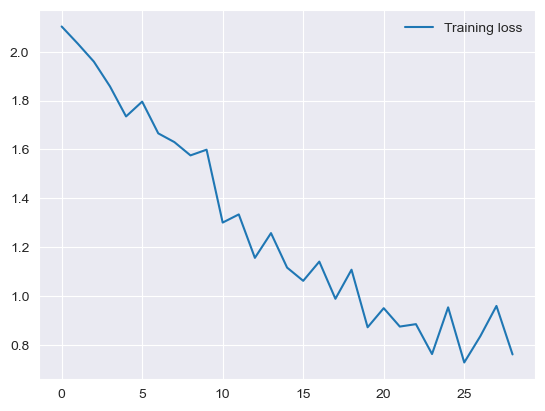

In [10]:
# Load the model with least loss
model.load_state_dict(torch.load("model_epoch30.pt"))

# Plotting the graph for Validation and Training Losses wrt Steps
plt.plot(loss_stats['train'], label='Training loss')
plt.legend(frameon=False)

In [11]:
model.eval() # Prep model for Evaluation

mean_of = 5 # Mean of how many evaluations
valid_loss = 0.0
class_correct = list(0. for i in range(8)) # List of number of correct predictions in each class
class_total = list(0. for i in range(8)) # List of total number of samples in each class

for i in range(mean_of):
    for data, target in test_loader:
        # Move the data to device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        valid_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

        # calculate test accuracy for each object class
        for i in range(len(target)):    
            label = target.data[i]
            if len(target) == 1:
                class_correct[label] += correct.item()
            else:
                class_correct[label] += correct[i].item()
            class_total[label] += 1

        # calculate and print average test loss
        valid_loss = valid_loss/(mean_of * len(test_loader.dataset))
        print('Test Loss: {:.6f}\n'.format(valid_loss))

        # print accuracy of each class
        for i in range(8):
            if class_total[i] > 0:
                print('Test Accuracy of %5s: %0.2f%% (%2d/%2d)' % (
                    str(i), 100 * class_correct[i] / class_total[i],
                    np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
                print('Test Accuracy of %5s: N/A (no training examples)' % (i))
            acc = 100. * np.sum(class_correct) / np.sum(class_total)

        # print total accuracy of the model
        print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
        acc,
        np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.021424

Test Accuracy of     0: 0.00% ( 0/ 1)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3: N/A (no training examples)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5: N/A (no training examples)
Test Accuracy of     6: N/A (no training examples)
Test Accuracy of     7: N/A (no training examples)

Test Accuracy (Overall): 0.00% ( 0/ 1)
Test Loss: 0.000812

Test Accuracy of     0: 50.00% ( 1/ 2)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3: N/A (no training examples)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5: N/A (no training examples)
Test Accuracy of     6: N/A (no training examples)
Test Accuracy of     7: N/A (no training examples)

Test Accuracy (Overall): 50.00% ( 1/ 2)
Test Loss: 0.020041

Test Accuracy of     0: 33.33% ( 1/ 3)
Test Accuracy of     1: N/

Test Loss: 0.021723

Test Accuracy of     0: 25.00% ( 1/ 4)
Test Accuracy of     1: 0.00% ( 0/ 5)
Test Accuracy of     2: 50.00% ( 2/ 4)
Test Accuracy of     3: 33.33% ( 1/ 3)
Test Accuracy of     4: 33.33% ( 1/ 3)
Test Accuracy of     5: 0.00% ( 0/ 1)
Test Accuracy of     6: N/A (no training examples)
Test Accuracy of     7: N/A (no training examples)

Test Accuracy (Overall): 25.00% ( 5/20)
Test Loss: 0.027651

Test Accuracy of     0: 25.00% ( 1/ 4)
Test Accuracy of     1: 0.00% ( 0/ 5)
Test Accuracy of     2: 50.00% ( 2/ 4)
Test Accuracy of     3: 33.33% ( 1/ 3)
Test Accuracy of     4: 33.33% ( 1/ 3)
Test Accuracy of     5: 0.00% ( 0/ 2)
Test Accuracy of     6: N/A (no training examples)
Test Accuracy of     7: N/A (no training examples)

Test Accuracy (Overall): 23.81% ( 5/21)
Test Loss: 0.003213

Test Accuracy of     0: 25.00% ( 1/ 4)
Test Accuracy of     1: 0.00% ( 0/ 5)
Test Accuracy of     2: 50.00% ( 2/ 4)
Test Accuracy of     3: 33.33% ( 1/ 3)
Test Accuracy of     4: 33.33% (

Test Loss: 0.001737

Test Accuracy of     0: 25.00% ( 2/ 8)
Test Accuracy of     1: 0.00% ( 0/10)
Test Accuracy of     2: 57.14% ( 4/ 7)
Test Accuracy of     3: 33.33% ( 1/ 3)
Test Accuracy of     4: 33.33% ( 1/ 3)
Test Accuracy of     5: 33.33% ( 1/ 3)
Test Accuracy of     6: 75.00% ( 3/ 4)
Test Accuracy of     7: 0.00% ( 0/ 5)

Test Accuracy (Overall): 27.91% (12/43)
Test Loss: 0.018387

Test Accuracy of     0: 25.00% ( 2/ 8)
Test Accuracy of     1: 0.00% ( 0/10)
Test Accuracy of     2: 50.00% ( 4/ 8)
Test Accuracy of     3: 33.33% ( 1/ 3)
Test Accuracy of     4: 33.33% ( 1/ 3)
Test Accuracy of     5: 33.33% ( 1/ 3)
Test Accuracy of     6: 75.00% ( 3/ 4)
Test Accuracy of     7: 0.00% ( 0/ 5)

Test Accuracy (Overall): 27.27% (12/44)
Test Loss: 0.013371

Test Accuracy of     0: 25.00% ( 2/ 8)
Test Accuracy of     1: 0.00% ( 0/10)
Test Accuracy of     2: 50.00% ( 4/ 8)
Test Accuracy of     3: 25.00% ( 1/ 4)
Test Accuracy of     4: 33.33% ( 1/ 3)
Test Accuracy of     5: 33.33% ( 1/ 3)
Te

Test Loss: 0.017466

Test Accuracy of     0: 25.00% ( 3/12)
Test Accuracy of     1: 0.00% ( 0/10)
Test Accuracy of     2: 50.00% ( 4/ 8)
Test Accuracy of     3: 33.33% ( 2/ 6)
Test Accuracy of     4: 33.33% ( 2/ 6)
Test Accuracy of     5: 33.33% ( 2/ 6)
Test Accuracy of     6: 75.00% ( 6/ 8)
Test Accuracy of     7: 0.00% ( 0/10)

Test Accuracy (Overall): 28.79% (19/66)
Test Loss: 0.011599

Test Accuracy of     0: 25.00% ( 3/12)
Test Accuracy of     1: 0.00% ( 0/11)
Test Accuracy of     2: 50.00% ( 4/ 8)
Test Accuracy of     3: 33.33% ( 2/ 6)
Test Accuracy of     4: 33.33% ( 2/ 6)
Test Accuracy of     5: 33.33% ( 2/ 6)
Test Accuracy of     6: 75.00% ( 6/ 8)
Test Accuracy of     7: 0.00% ( 0/10)

Test Accuracy (Overall): 28.36% (19/67)
Test Loss: 0.010895

Test Accuracy of     0: 25.00% ( 3/12)
Test Accuracy of     1: 0.00% ( 0/12)
Test Accuracy of     2: 50.00% ( 4/ 8)
Test Accuracy of     3: 33.33% ( 2/ 6)
Test Accuracy of     4: 33.33% ( 2/ 6)
Test Accuracy of     5: 33.33% ( 2/ 6)
Te

Test Loss: 0.043974

Test Accuracy of     0: 25.00% ( 3/12)
Test Accuracy of     1: 0.00% ( 0/15)
Test Accuracy of     2: 50.00% ( 6/12)
Test Accuracy of     3: 33.33% ( 3/ 9)
Test Accuracy of     4: 33.33% ( 3/ 9)
Test Accuracy of     5: 33.33% ( 3/ 9)
Test Accuracy of     6: 75.00% ( 9/12)
Test Accuracy of     7: 0.00% ( 0/11)

Test Accuracy (Overall): 30.34% (27/89)
Test Loss: 0.058582

Test Accuracy of     0: 25.00% ( 3/12)
Test Accuracy of     1: 0.00% ( 0/15)
Test Accuracy of     2: 50.00% ( 6/12)
Test Accuracy of     3: 33.33% ( 3/ 9)
Test Accuracy of     4: 33.33% ( 3/ 9)
Test Accuracy of     5: 33.33% ( 3/ 9)
Test Accuracy of     6: 75.00% ( 9/12)
Test Accuracy of     7: 0.00% ( 0/12)

Test Accuracy (Overall): 30.00% (27/90)
Test Loss: 0.052027

Test Accuracy of     0: 25.00% ( 3/12)
Test Accuracy of     1: 0.00% ( 0/15)
Test Accuracy of     2: 50.00% ( 6/12)
Test Accuracy of     3: 33.33% ( 3/ 9)
Test Accuracy of     4: 33.33% ( 3/ 9)
Test Accuracy of     5: 33.33% ( 3/ 9)
Te

Test Loss: 0.025939

Test Accuracy of     0: 25.00% ( 4/16)
Test Accuracy of     1: 0.00% ( 0/20)
Test Accuracy of     2: 50.00% ( 8/16)
Test Accuracy of     3: 33.33% ( 4/12)
Test Accuracy of     4: 36.36% ( 4/11)
Test Accuracy of     5: 33.33% ( 3/ 9)
Test Accuracy of     6: 75.00% ( 9/12)
Test Accuracy of     7: 0.00% ( 0/15)

Test Accuracy (Overall): 28.83% (32/111)
Test Loss: 0.007792

Test Accuracy of     0: 25.00% ( 4/16)
Test Accuracy of     1: 0.00% ( 0/20)
Test Accuracy of     2: 50.00% ( 8/16)
Test Accuracy of     3: 33.33% ( 4/12)
Test Accuracy of     4: 33.33% ( 4/12)
Test Accuracy of     5: 33.33% ( 3/ 9)
Test Accuracy of     6: 75.00% ( 9/12)
Test Accuracy of     7: 0.00% ( 0/15)

Test Accuracy (Overall): 28.57% (32/112)
Test Loss: 0.021723

Test Accuracy of     0: 25.00% ( 4/16)
Test Accuracy of     1: 0.00% ( 0/20)
Test Accuracy of     2: 50.00% ( 8/16)
Test Accuracy of     3: 33.33% ( 4/12)
Test Accuracy of     4: 33.33% ( 4/12)
Test Accuracy of     5: 30.00% ( 3/10)


Test Loss: 0.022005

Test Accuracy of     0: 25.00% ( 5/20)
Test Accuracy of     1: 0.00% ( 0/25)
Test Accuracy of     2: 50.00% ( 8/16)
Test Accuracy of     3: 33.33% ( 4/12)
Test Accuracy of     4: 33.33% ( 4/12)
Test Accuracy of     5: 33.33% ( 4/12)
Test Accuracy of     6: 75.00% (12/16)
Test Accuracy of     7: 0.00% ( 0/20)

Test Accuracy (Overall): 27.82% (37/133)
Test Loss: 0.029821

Test Accuracy of     0: 25.00% ( 5/20)
Test Accuracy of     1: 0.00% ( 0/25)
Test Accuracy of     2: 47.06% ( 8/17)
Test Accuracy of     3: 33.33% ( 4/12)
Test Accuracy of     4: 33.33% ( 4/12)
Test Accuracy of     5: 33.33% ( 4/12)
Test Accuracy of     6: 75.00% (12/16)
Test Accuracy of     7: 0.00% ( 0/20)

Test Accuracy (Overall): 27.61% (37/134)
Test Loss: 0.006838

Test Accuracy of     0: 25.00% ( 5/20)
Test Accuracy of     1: 0.00% ( 0/25)
Test Accuracy of     2: 50.00% ( 9/18)
Test Accuracy of     3: 33.33% ( 4/12)
Test Accuracy of     4: 33.33% ( 4/12)
Test Accuracy of     5: 33.33% ( 4/12)


Test Loss: 0.008532

Test Accuracy of     0: 25.00% ( 5/20)
Test Accuracy of     1: 0.00% ( 0/25)
Test Accuracy of     2: 50.00% (10/20)
Test Accuracy of     3: 33.33% ( 5/15)
Test Accuracy of     4: 33.33% ( 5/15)
Test Accuracy of     5: 33.33% ( 5/15)
Test Accuracy of     6: 75.00% (15/20)
Test Accuracy of     7: 0.00% ( 0/25)

Test Accuracy (Overall): 29.03% (45/155)


In [112]:
print("Begin training.")
for e in tqdm(range(1, 15)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for images, labels in train_loader:
        # Move tensor to device('cuda' in case of GPU or 'cpu' in case of CPU)
        images, labels = images.to(device), labels.to(device)
        # Clearing all the previous gradients
        optimizer.zero_grad()
        # Forward Pass
        logits = model(images)
        # Loss calculation
        loss = criterion(logits,labels)
        # Backward Pass
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Updating the losses list
        train_epoch_loss += loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f}')
    
torch.save(model.state_dict(), 'model.pt')

Begin training.


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 2.09304
Epoch 02: | Train Loss: 2.06530
Epoch 03: | Train Loss: 1.97574
Epoch 04: | Train Loss: 1.89062
Epoch 05: | Train Loss: 1.80476
Epoch 06: | Train Loss: 1.62493
Epoch 07: | Train Loss: 1.71389
Epoch 08: | Train Loss: 1.53551
Epoch 09: | Train Loss: 1.63614
Epoch 10: | Train Loss: 1.53759
Epoch 11: | Train Loss: 1.40136
Epoch 12: | Train Loss: 1.35527
Epoch 13: | Train Loss: 1.34124
Epoch 14: | Train Loss: 1.10352


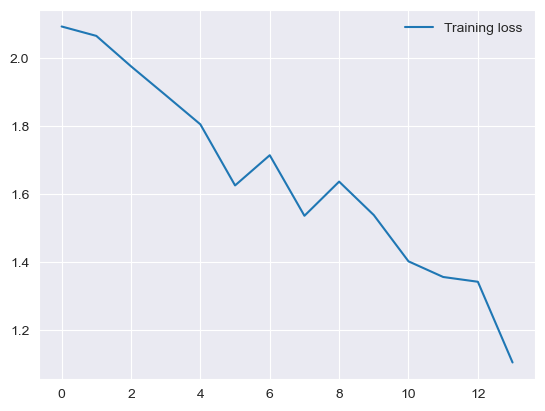

In [113]:
# Load the model with least loss
model.load_state_dict(torch.load("model.pt"))

# Plotting the graph for Validation and Training Losses wrt Steps
plt.plot(loss_stats['train'], label='Training loss')
plt.legend(frameon=False)

In [115]:
model.eval() # Prep model for Evaluation

mean_of = 5 # Mean of how many evaluations
valid_loss = 0.0
class_correct = list(0. for i in range(8)) # List of number of correct predictions in each class
class_total = list(0. for i in range(8)) # List of total number of samples in each class

for i in range(mean_of):
    for data, target in test_loader:
        # Move the data to device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        valid_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

        # calculate test accuracy for each object class
        for i in range(len(target)):    
            label = target.data[i]
            if len(target) == 1:
                class_correct[label] += correct.item()
            else:
                class_correct[label] += correct[i].item()
            class_total[label] += 1

        # calculate and print average test loss
        valid_loss = valid_loss/(mean_of * len(test_loader.dataset))
        print('Test Loss: {:.6f}\n'.format(valid_loss))

        # print accuracy of each class
        for i in range(8):
            if class_total[i] > 0:
                print('Test Accuracy of %5s: %0.2f%% (%2d/%2d)' % (
                    str(i), 100 * class_correct[i] / class_total[i],
                    np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
                print('Test Accuracy of %5s: N/A (no training examples)' % (i))
            acc = 100. * np.sum(class_correct) / np.sum(class_total)

        # print total accuracy of the model
        print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
        acc,
        np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.012398

Test Accuracy of     0: 0.00% ( 0/ 1)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3: N/A (no training examples)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5: N/A (no training examples)
Test Accuracy of     6: N/A (no training examples)
Test Accuracy of     7: N/A (no training examples)

Test Accuracy (Overall): 0.00% ( 0/ 1)
Test Loss: 0.004608

Test Accuracy of     0: 50.00% ( 1/ 2)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3: N/A (no training examples)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5: N/A (no training examples)
Test Accuracy of     6: N/A (no training examples)
Test Accuracy of     7: N/A (no training examples)

Test Accuracy (Overall): 50.00% ( 1/ 2)
Test Loss: 0.006222

Test Accuracy of     0: 66.67% ( 2/ 3)
Test Accuracy of     1: N/

Test Loss: 0.020550

Test Accuracy of     0: 75.00% ( 3/ 4)
Test Accuracy of     1: 20.00% ( 1/ 5)
Test Accuracy of     2: 25.00% ( 1/ 4)
Test Accuracy of     3: 0.00% ( 0/ 3)
Test Accuracy of     4: 66.67% ( 2/ 3)
Test Accuracy of     5: 0.00% ( 0/ 2)
Test Accuracy of     6: N/A (no training examples)
Test Accuracy of     7: N/A (no training examples)

Test Accuracy (Overall): 33.33% ( 7/21)
Test Loss: 0.007278

Test Accuracy of     0: 75.00% ( 3/ 4)
Test Accuracy of     1: 20.00% ( 1/ 5)
Test Accuracy of     2: 25.00% ( 1/ 4)
Test Accuracy of     3: 0.00% ( 0/ 3)
Test Accuracy of     4: 66.67% ( 2/ 3)
Test Accuracy of     5: 0.00% ( 0/ 3)
Test Accuracy of     6: N/A (no training examples)
Test Accuracy of     7: N/A (no training examples)

Test Accuracy (Overall): 31.82% ( 7/22)
Test Loss: 0.005886

Test Accuracy of     0: 75.00% ( 3/ 4)
Test Accuracy of     1: 20.00% ( 1/ 5)
Test Accuracy of     2: 25.00% ( 1/ 4)
Test Accuracy of     3: 0.00% ( 0/ 3)
Test Accuracy of     4: 66.67% (

Test Loss: 0.003420

Test Accuracy of     0: 75.00% ( 6/ 8)
Test Accuracy of     1: 20.00% ( 2/10)
Test Accuracy of     2: 28.57% ( 2/ 7)
Test Accuracy of     3: 0.00% ( 0/ 3)
Test Accuracy of     4: 66.67% ( 2/ 3)
Test Accuracy of     5: 0.00% ( 0/ 3)
Test Accuracy of     6: 50.00% ( 2/ 4)
Test Accuracy of     7: 20.00% ( 1/ 5)

Test Accuracy (Overall): 34.88% (15/43)
Test Loss: 0.011807

Test Accuracy of     0: 75.00% ( 6/ 8)
Test Accuracy of     1: 20.00% ( 2/10)
Test Accuracy of     2: 25.00% ( 2/ 8)
Test Accuracy of     3: 0.00% ( 0/ 3)
Test Accuracy of     4: 66.67% ( 2/ 3)
Test Accuracy of     5: 0.00% ( 0/ 3)
Test Accuracy of     6: 50.00% ( 2/ 4)
Test Accuracy of     7: 20.00% ( 1/ 5)

Test Accuracy (Overall): 34.09% (15/44)
Test Loss: 0.020024

Test Accuracy of     0: 75.00% ( 6/ 8)
Test Accuracy of     1: 20.00% ( 2/10)
Test Accuracy of     2: 25.00% ( 2/ 8)
Test Accuracy of     3: 0.00% ( 0/ 4)
Test Accuracy of     4: 66.67% ( 2/ 3)
Test Accuracy of     5: 0.00% ( 0/ 3)
Tes

Test Loss: 0.008671

Test Accuracy of     0: 75.00% ( 9/12)
Test Accuracy of     1: 27.27% ( 3/11)
Test Accuracy of     2: 25.00% ( 2/ 8)
Test Accuracy of     3: 0.00% ( 0/ 6)
Test Accuracy of     4: 66.67% ( 4/ 6)
Test Accuracy of     5: 0.00% ( 0/ 6)
Test Accuracy of     6: 50.00% ( 4/ 8)
Test Accuracy of     7: 20.00% ( 2/10)

Test Accuracy (Overall): 35.82% (24/67)
Test Loss: 0.009467

Test Accuracy of     0: 75.00% ( 9/12)
Test Accuracy of     1: 25.00% ( 3/12)
Test Accuracy of     2: 25.00% ( 2/ 8)
Test Accuracy of     3: 0.00% ( 0/ 6)
Test Accuracy of     4: 66.67% ( 4/ 6)
Test Accuracy of     5: 0.00% ( 0/ 6)
Test Accuracy of     6: 50.00% ( 4/ 8)
Test Accuracy of     7: 20.00% ( 2/10)

Test Accuracy (Overall): 35.29% (24/68)
Test Loss: 0.010846

Test Accuracy of     0: 75.00% ( 9/12)
Test Accuracy of     1: 23.08% ( 3/13)
Test Accuracy of     2: 25.00% ( 2/ 8)
Test Accuracy of     3: 0.00% ( 0/ 6)
Test Accuracy of     4: 66.67% ( 4/ 6)
Test Accuracy of     5: 0.00% ( 0/ 6)
Tes

Test Loss: 0.017802

Test Accuracy of     0: 75.00% ( 9/12)
Test Accuracy of     1: 20.00% ( 3/15)
Test Accuracy of     2: 25.00% ( 3/12)
Test Accuracy of     3: 0.00% ( 0/ 9)
Test Accuracy of     4: 66.67% ( 6/ 9)
Test Accuracy of     5: 0.00% ( 0/ 9)
Test Accuracy of     6: 50.00% ( 6/12)
Test Accuracy of     7: 15.38% ( 2/13)

Test Accuracy (Overall): 31.87% (29/91)
Test Loss: 0.018699

Test Accuracy of     0: 75.00% ( 9/12)
Test Accuracy of     1: 20.00% ( 3/15)
Test Accuracy of     2: 25.00% ( 3/12)
Test Accuracy of     3: 0.00% ( 0/ 9)
Test Accuracy of     4: 66.67% ( 6/ 9)
Test Accuracy of     5: 0.00% ( 0/ 9)
Test Accuracy of     6: 50.00% ( 6/12)
Test Accuracy of     7: 14.29% ( 2/14)

Test Accuracy (Overall): 31.52% (29/92)
Test Loss: 0.007210

Test Accuracy of     0: 75.00% ( 9/12)
Test Accuracy of     1: 20.00% ( 3/15)
Test Accuracy of     2: 25.00% ( 3/12)
Test Accuracy of     3: 0.00% ( 0/ 9)
Test Accuracy of     4: 66.67% ( 6/ 9)
Test Accuracy of     5: 0.00% ( 0/ 9)
Tes

Test Loss: 0.012895

Test Accuracy of     0: 75.00% (12/16)
Test Accuracy of     1: 20.00% ( 4/20)
Test Accuracy of     2: 25.00% ( 4/16)
Test Accuracy of     3: 0.00% ( 0/12)
Test Accuracy of     4: 66.67% ( 8/12)
Test Accuracy of     5: 0.00% ( 0/10)
Test Accuracy of     6: 50.00% ( 6/12)
Test Accuracy of     7: 20.00% ( 3/15)

Test Accuracy (Overall): 32.74% (37/113)
Test Loss: 0.020550

Test Accuracy of     0: 75.00% (12/16)
Test Accuracy of     1: 20.00% ( 4/20)
Test Accuracy of     2: 25.00% ( 4/16)
Test Accuracy of     3: 0.00% ( 0/12)
Test Accuracy of     4: 66.67% ( 8/12)
Test Accuracy of     5: 0.00% ( 0/11)
Test Accuracy of     6: 50.00% ( 6/12)
Test Accuracy of     7: 20.00% ( 3/15)

Test Accuracy (Overall): 32.46% (37/114)
Test Loss: 0.007278

Test Accuracy of     0: 75.00% (12/16)
Test Accuracy of     1: 20.00% ( 4/20)
Test Accuracy of     2: 25.00% ( 4/16)
Test Accuracy of     3: 0.00% ( 0/12)
Test Accuracy of     4: 66.67% ( 8/12)
Test Accuracy of     5: 0.00% ( 0/12)
T

Test Loss: 0.012171

Test Accuracy of     0: 75.00% (15/20)
Test Accuracy of     1: 20.00% ( 5/25)
Test Accuracy of     2: 22.22% ( 4/18)
Test Accuracy of     3: 0.00% ( 0/12)
Test Accuracy of     4: 66.67% ( 8/12)
Test Accuracy of     5: 0.00% ( 0/12)
Test Accuracy of     6: 50.00% ( 8/16)
Test Accuracy of     7: 20.00% ( 4/20)

Test Accuracy (Overall): 32.59% (44/135)
Test Loss: 0.003420

Test Accuracy of     0: 75.00% (15/20)
Test Accuracy of     1: 20.00% ( 5/25)
Test Accuracy of     2: 26.32% ( 5/19)
Test Accuracy of     3: 0.00% ( 0/12)
Test Accuracy of     4: 66.67% ( 8/12)
Test Accuracy of     5: 0.00% ( 0/12)
Test Accuracy of     6: 50.00% ( 8/16)
Test Accuracy of     7: 20.00% ( 4/20)

Test Accuracy (Overall): 33.09% (45/136)
Test Loss: 0.011807

Test Accuracy of     0: 75.00% (15/20)
Test Accuracy of     1: 20.00% ( 5/25)
Test Accuracy of     2: 25.00% ( 5/20)
Test Accuracy of     3: 0.00% ( 0/12)
Test Accuracy of     4: 66.67% ( 8/12)
Test Accuracy of     5: 0.00% ( 0/12)
T

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 53 * 53, 1024)
        self.fc2 = nn.Linear(1024, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*53*53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=89888, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [13]:
loss_stats = {
    'train': [],
    "val": []
}

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.classifier.parameters(),lr = 0.1)

In [15]:
print("Begin training.")
for e in tqdm(range(1, 15)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    net.train()
    for images, labels in train_loader:
        # Move tensor to device('cuda' in case of GPU or 'cpu' in case of CPU)
        images, labels = images.to(device), labels.to(device)
        # Clearing all the previous gradients
        optimizer.zero_grad()
        # Forward Pass
        logits = net(images)
        # Loss calculation
        loss = criterion(logits,labels)
        # Backward Pass
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Updating the losses list
        train_epoch_loss += loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f}')
    
torch.save(net.state_dict(), 'net.pt')

Begin training.


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 2.31183
Epoch 02: | Train Loss: 2.31075
Epoch 03: | Train Loss: 2.30792
Epoch 04: | Train Loss: 2.30713
Epoch 05: | Train Loss: 2.31020
Epoch 06: | Train Loss: 2.30992
Epoch 07: | Train Loss: 2.30839
Epoch 08: | Train Loss: 2.30988
Epoch 09: | Train Loss: 2.31093
Epoch 10: | Train Loss: 2.31096
Epoch 11: | Train Loss: 2.31148
Epoch 12: | Train Loss: 2.30799
Epoch 13: | Train Loss: 2.30919
Epoch 14: | Train Loss: 2.31113
